# Background and external source data analysis in GXe XAMSL

_16-6-2021_

For more details about the measurements, look at the database in the wiki-page: https://wiki.nikhef.nl/xenon/doku.php?id=xamsl:1st_gxe_measurements

The aim of this analysis is:
  * **TASK 1**: calculate the data rate of coincidence events and look at their energy spectrum in the background runs (e.g. can you identify muons in the data?)
  * **TASK 2**: make an inspection of the single digitizer channels, focusing on the data rate and the spectrum registered per channel
  * **TASK 3**: calculate the data rate of coincidence events and look at their energy spectrum in the runs where we used an external source (Na-222 and Co-60)
  
**Comments**:

A digitizer is the electronic module used to read out the signals from the XAMSL PMTs. Our digitizer has 8 channels (named from 0 to 7), and one of our goal is to inspect each channels pair to see if there are any difference among them that leads us to choose one particular pair. 

A coincidence event is defined when both PMT1 (bottom) and PMT2 (top) trigger a signal in the same time window.

### Data structure

In this notebook, we will go through different data 'levels': 'low-processed' data come directly from the digitizer readout (**raw-data**), but in order to perform our analysis we need most of the time 'high-processed' data, which are the same data but with different and more elaborated fields. 

You had already some introduction about this, so we just give you the list of the data-structures you can use!

The data structure is described in detail in the following webpage:
https://straxen.readthedocs.io/en/latest/reference/datastructure_nT.html
Click on 'straxen nT datastructure' (in the menu left) then a list of all different 'data-kinds' open where you find also the discussed data-kinds 'raw-record', 'peaks', 'peak_basics', ... Click on 'description' to see which variable are available at which data-kind.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numba
import os
import pickle
from datetime import datetime
from IPython import display

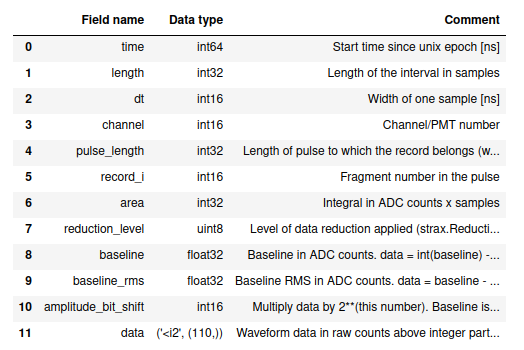

In [2]:
# Uncomment the line of the data-structure you want to look the fields of

#display.Image("./raw_records.png")
display.Image("./records.png")
#display.Image("./data_structure_peaks.png")
#display.Image("./peak_basics.png")

## TASK 1 & Task 2: Background data

  1. Load the data ``raw_records``, ``records`` and ``peak_basics`` of each run
  2. Calculate the total length (in time) of the run and compare it with the approximative value written in the wiki-database
  3. Calculate the rate of events (events/sec) in both channels and compare the results with each other. In the ideal case you also plot a histogram of the 'time' variable (see an example later in this note).
  4. Calculate the rate of coincidence events in the run
  5. Look at the energy spectrum in ADC counts (``records`` level) and compare between the two channels:
     * Do you see any peak? And can you define at which ADC count value it is ?
  6. For the coincidence events, look at the energy spectrum in area [a.u.] (``peak_basics`` level):
     * Do you see any peak? And can you define at which area value it is?
  7. Compare the variable 'baseline' (raw-records) among the different channels.

    
**RUNS TO USE**: ``000109``, (``000113``-``000119``)

## TASK 3: External Source data

  1. Load the data
  2. Calculate the rate of coincidence events in the run
  3. Look at the energy spectrum in ADC counts and in area 
  4. Data interpretation: comparison with Background data?
    
**RUNS TO USE**: ``000124``, ``000125``, ``000126``, ``000127``

## Load the data

In [3]:
print('<-------------------Un-Pickling data kinds for Run 000109----------------------->')

# Read the pickle file
pickefile_rr = open('raw_records_000109', 'rb')
picklefile_rec = open('records_000109', 'rb')
picklefile_p = open('records_000109', 'rb')
picklefile_pb = open('records_000109', 'rb')

# Unpickle the dataframe (load the data)
raw_rec_000109 = pickle.load(pickefile_rr)
records_000109 = pickle.load(picklefile_rec)
peaks_000109 = pickle.load(picklefile_p)
peak_basics_000109 = pickle.load(picklefile_pb)

# Close file
pickefile_rr.close()
picklefile_rec.close()
picklefile_p.close()
picklefile_pb.close()

# Print the dataframe

<-------------------Un-Pickling data kinds for Run 000109----------------------->


For the sub-Tasks 1-3 you can use the data kinds ``raw_records`` and ``records``.

For the total length of the run, look at the ``time`` fields and take into account that the data is a matrix of (records, samples), where '**records**' are just fragments that conveniently divide the total run and '**samples**' is the number of samples per record. Each sample is **10ns** long.

In [4]:
# Look at the shape of data (records, samples)
raw_rec_000109['data'].shape

(2285, 110)

## Some helping functions/plots

### Length of a run:

In [16]:
# Calculate the length of the run in seconds

#gives the time of the 1st recorded pulse with respect to the start of the run
start_run = raw_rec_000109['time'][0] 

# number of pulses in the run = length of the array
number_of_pulses = len(raw_rec_000109['time']) 

# for the end-time we take the time of the last recorded pulse. the -1 comes since we start counting form '0',
# while the len() function starts from '1'
end_run = raw_rec_000109['time'][number_of_pulses-1]


### Monitor rate over time:

One can monitor easily the rate over time by plotting a histogram of the 'time' varable. A primitive example is given in the plot below. If there would be a 'burst' of events (we observed something like this previously) at a certain time, you would see it in the plot below by an upwards-shooting of the number of events at that time.

**NOTE:** In the plot below I plot all event of both channels the same time. If you want to look into one specific channel, you need to select this data, e.g., by applying a cut on the channel number of the pulse (raw_rec_000109['channel'] variable).

Text(0, 0.5, 'number of events')

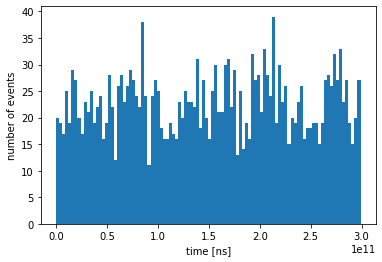

In [11]:

plt.hist(raw_rec_000109['time'],bins = 100);
plt.xlabel('time [ns]')
plt.ylabel('number of events')

### Calculate event-rate of each channel

There isn't so much to say! Event rate is the number of recorded pulses of a certain channel divided by the length of the run.

We want to have this number for each channel since the event rate can be at different values, e.g., when one channel has many noise events we are not intrested in.

### Coincidence events

Since PMTs can be noisy, we require from a $real$ event that this event is seen from both PMTs at the same time (coincident detection). For our data this means that the signal has been seen by both channels. 

At 'peaks' level, this is easy to check since this data-kind has the variable 'area_by_channel'. At other data-kinds at lower levels (raw-records) you would need to look yourself if you find in the pulses of both channels two which happened at the same time.

## Energy spectrum

You can obtain the spectrum by selecting the following data types:

  * ``records_000109['area']`` contains the height of the recorded peak/signal from all channels in [ADC counts]

  * ``peaks_000109['area']`` contains the height of the recorded peak/signal from all channels in [a.u]